In [1]:
import re
import shutil
import os
import random
import time
from datetime import datetime

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim


from tqdm.auto import tqdm

import PIL
import PIL.Image
import cv2
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


matplotlib.style.use('ggplot')

/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONSTANTES
LABBELS_NAMES = ['01-Normal', '02-Tapered', '03-Pyriform', '04-Small', '05-Amorphous']

## 1. CARGAR ARCHIVOS

In [3]:
# Se crea un archivo en la direccion ingresada, esta se elimina si ya existe.
def create_folder( folder_name, dest_path ):
    try:
        folder_path = dest_path+'/'+folder_name
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)   
        os.mkdir(folder_path)
        return True
    except OSError as err:
        print("OS error:", err)

In [4]:
# Se crea un archivo en la direccion ingresada
def create_folder_wremoving( folder_name, dest_path ):
    try:
        folder_path = dest_path+folder_name
        if not(os.path.exists(folder_path)):
            os.mkdir(folder_path)
        return True
    except OSError as err:
        print("OS error:", err)

In [5]:
# Se crea el data-set a partir de la informacion presente en expertAnotations.txt, y las partialImages de entrada.
def create_dataset(path_expertAnotations,path_partialImages, dest_path, dataset_name):
    try:
        file = open(path_expertAnotations, 'r')
        create_folder(dataset_name, dest_path)
        for labbel_name in LABBELS_NAMES:
            create_folder( labbel_name ,dest_path+'/'+dataset_name)
        for x in file:
            # Se obtiene el nombre y clase desde el archivo txt
            aux1 = x.split('	')
            aux2 = aux1[0].replace('\n','').split('-')
            aux3 = aux2[2].split('/')
            clase = int(aux1[4].replace('\n',''))
            p = aux2[0]
            pl = aux2[1]
            n_sample = int(re.split('(\d+)',aux3[0])[1])
            n_sperm = int(re.split('(\d+)',aux3[1])[1])
            # Se conforma el directorio de la imagen a partir de la informacion anterior.
            file = path_partialImages+'ch00_'+p+'-'+pl+'-sample'+str(n_sample)+'-sperm'+str(n_sperm)+'.tif'
            # Se conforma el directorio donde se va a copiar la imagen
            aux = dest_path+'/'+dataset_name+'/'
            if (clase == 0):
                aux=aux+'01-Normal'
            elif (clase == 1):
                aux=aux+'02-Tapered'
            elif (clase == 2):
                aux=aux+'03-Pyriform'
            elif (clase == 3):
                aux=aux+'04-Small'
            else:
                aux=aux+'05-Amorphous'
            # Se copia la imagen
            shutil.copy(file,aux)  
        return True
    except OSError as err:
        print("OS error:", err)
    

In [6]:
def copy_element(origin_path, dest_path):
    try:
        shutil.copy( origin_path, dest_path)
        return True
    except OSError as err:
        print("OS error:", err)

In [7]:
# Elige aleatoriamente un elemento de la lista, y luego lo elimina de esta.
def choose_random_element(elements_list):
    element = random.choice(elements_list)
    elements_list.remove(element)
    return element

In [8]:
# Se crean los conjuntos train, valid y test a partir de las imagenes.
def create_train_valid_test( origin_path, dest_path, dataset_name,porcentages):
    create_folder(dataset_name, dest_path)
    dataset_path = dest_path+'/'+dataset_name
    create_folder('train', dataset_path)
    create_folder('test', dataset_path)
    create_folder('valid', dataset_path)
    
    for labbel_name in LABBELS_NAMES:
        create_folder( labbel_name, dataset_path+'/train' )
        create_folder( labbel_name, dataset_path+'/test' )
        create_folder( labbel_name, dataset_path+'/valid' )
        try:
            all_class_images = os.listdir(origin_path+'/'+labbel_name)
            count_class_images = len(all_class_images)
            origin_class_path = origin_path+'/'+labbel_name
            # Archivos test
            aux_count = 0
            while int(count_class_images*porcentages[0]) > aux_count:
                image_name = choose_random_element(all_class_images)
                copy_element( origin_class_path+'/'+image_name, dataset_path+'/test/'+labbel_name+'/'+image_name)
                aux_count = aux_count+1
            aux_count = 0
            # Archivos valid
            while int(count_class_images*porcentages[1]) > aux_count:
                image_name = choose_random_element(all_class_images)
                copy_element( origin_class_path+'/'+image_name, dataset_path+'/valid/'+labbel_name+'/'+image_name)
                aux_count = aux_count+1
            aux_count = 0
             # Archivos train
            while len(all_class_images) != 0:
                image_name = choose_random_element(all_class_images)
                copy_element( origin_class_path+'/'+image_name, dataset_path+'/train/'+labbel_name+'/'+image_name)
        except OSError as err:
            print("OS error:", err)

In [9]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_data_tf_format(data_path, batch_size, target_size):
    
    dataGen_train = ImageDataGenerator(rescale = 1./255) 
    dataGen_valid = ImageDataGenerator(rescale = 1./255)
    dataGen_test = ImageDataGenerator(rescale = 1./255)

    #test different color maps -  class modes and cross validation types
    train = dataGen_train.flow_from_directory(data_path+'/train',
                                                     target_size = target_size,
                                                     batch_size = batch_size,
                                                     shuffle = True,
                                                     class_mode="categorical")

    valid = dataGen_valid.flow_from_directory(data_path+'/valid',
                                                target_size = target_size,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                class_mode="categorical")

    test = dataGen_test.flow_from_directory(data_path+'/test',
                                                target_size = target_size,
                                                batch_size = 1,
                                                shuffle = True,
                                                class_mode="categorical")
    return train,valid,test

In [10]:
def load_data_pytorch_format( dataset_path, batch_size, image_dimention ):
    
    transform = transforms.Compose([
        transforms.Resize(image_dimention[0]),
        transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(root=dataset_path+'/train', 
                                         transform=transform)
    valid_dataset = datasets.ImageFolder(root=dataset_path+'/valid',
                                         transform=transform)
    test_dataset = datasets.ImageFolder(root=dataset_path+'/test',
                                        transform=transform)    

    train_loader = DataLoader( train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=1, 
                              pin_memory=True)
    valid_loader = DataLoader( valid_dataset, 
                              batch_size=batch_size, 
                              shuffle=True,
                              num_workers=1, 
                              pin_memory=True)
    test_loader = DataLoader( test_dataset, 
                             batch_size=batch_size, 
                             shuffle=True,
                             num_workers=1, 
                             pin_memory=True)

    return train_loader, valid_loader, test_loader

# 2.FUNCIONES DE DEEP LEARNING

In [28]:
def random_init(m):
    if type(m)==nn.Linear or type(m)==nn.Conv2d:
        m.weight.data=torch.randn(m.weight.size())*.01

In [11]:
def train(net, trainloader, optimizer, criterion , device):
    net.train()
    running_loss = 0.0
    running_acc = 0.0
    count_minibatchs = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)
        running_acc += (preds == labels).sum().item()

        count_minibatchs = i+1
        
    epoch_loss = running_loss / count_minibatchs
    epoch_acc = 100. * (running_acc / len(trainloader.dataset))
    print(f"loss: {epoch_loss:.3f}, accuracy: {epoch_acc:.3f}")
    return epoch_loss, epoch_acc

In [12]:
def validate(net, validloader, criterion, device):
    net.eval()
    running_loss = 0.0
    running_acc = 0.0
    count_minibatchs = 0
    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # forward
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            running_loss += loss.item()

            _, preds = torch.max(outputs.data, 1)
            running_acc += (preds == labels).sum().item()

            count_minibatchs = i+1
    epoch_loss = running_loss / count_minibatchs
    epoch_acc = 100. * (running_acc / len(validloader.dataset))
    print(f"val_loss: {epoch_loss:.3f}, val_accuracy: {epoch_acc:.3f}")
    return epoch_loss, epoch_acc


In [13]:
def test(net, testloader, device):
    y_pred, y_original = [], []
    for i, data in enumerate(testloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels

        # get original labbels
        y_original.extend(labels.numpy())

        # forward
        outputs=net(inputs)

        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu()
        y_pred.extend(preds.numpy())

    return y_pred,y_original

In [14]:
def load_model( net, model_state, device):
    net.load_state_dict( model_state )
    net.to(device)
    return net

In [15]:
def save_acc_plot(train_acc, valid_acc, model_save_path):
    try:
        plt.figure()
        plt.plot(train_acc, color='red', label='train acc')
        plt.plot(valid_acc, color='blue', label='valid acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig(model_save_path+'/accuracy.png')
        return True
    except:
        return False

In [16]:
def save_loss_plot(train_loss, valid_loss, model_save_path):
    try:
        plt.figure()
        plt.plot(train_loss, color='red', label='train loss')
        plt.plot(valid_loss, color='blue', label='valid loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(model_save_path+'/loss.png')    
        return True
    except:
        return False

In [1]:
def save_confusion_matrix(y_true, y_pred, model_save_path):
    cf_matrix = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    file= open(model_save_path+"/general_scores.txt","w+")
    file.write(f"Precision Score: {precision:.3f}\n")
    file.write(f"Recall Score: {recall:.3f}\n")
    file.write(f"F1 Score: {f1:.3f}\n")
    file.close()
    
    df_cm = pd.DataFrame(cf_matrix, index = [class_name for class_name in LABBELS_NAMES], columns = [class_name for class_name in LABBELS_NAMES])
    plt.figure()
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
    plt.savefig(model_save_path+'/confusion_matrix.png')

In [4]:
def process_net( net, epochs, trainloader, validloader, testloader, optimizer, criterion, model_save_path):
    aux = net
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    train_loss, valid_loss ,train_acc, valid_acc = [],[],[],[]
    
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    
    net = net.to(device)
    best_vloss = float('inf')
    best_model_state= []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_epoch_loss, train_epoch_acc = train(net, trainloader, optimizer, criterion,device)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)

        valid_epoch_loss, valid_epoch_acc = validate(net, validloader, criterion,device)        
        valid_loss.append(valid_epoch_loss)
        valid_acc.append(valid_epoch_acc)

        if valid_epoch_loss < best_vloss:
            best_vloss = valid_epoch_loss
            best_model_state = net.state_dict()
        print("\n\n")
        time.sleep(1)
        
    best_net = load_model( aux, best_model_state, device)
    time.sleep(1)
    y_pred,y_true = test(best_net, testloader, device)
    
    save_acc_plot(train_acc, valid_acc, model_save_path)
    save_loss_plot(train_loss, valid_loss, model_save_path)
    save_confusion_matrix(y_true, y_pred, model_save_path)

In [55]:
def fill_with_white_pixels( imag, pixel_list ):
    for element in pixel_list:
        i = element[0]
        j = element[1]
        imag[ i, j ] = 255
    

In [56]:
def get_most_frecuent_value( arr ):
    count = 0
    aux = arr[0]
    for i in range(len(arr)-1):
        frec = arr.count(arr[i])
        if(frec > count):
            count = frec
            aux = arr[i]
    return aux

In [57]:
def remove_elements(arr, element):
    return [x for x in arr if x != element]


In [58]:
def get_most_common_values( all_pixels ):
    all_pixels = remove_elements(all_pixels, 0)

    new_value1 = get_most_frecuent_value(all_pixels)
    all_pixels = remove_elements(all_pixels, new_value1)
    aux1 = new_value1
    
    return [aux1-1,aux1,aux1+1]

In [59]:
def get_black_dots( imag, i, j ):
    rows, cols = imag.shape
    list_elements = []
    list_elements.append([i,j])
    list_blackdots = []
    for element in list_elements:
        i = element[0]
        j = element[1]
        if( i < rows and j < cols and i >= 0 and j >= 0  ):
            if( imag[i,j] == 0  and ([i,j] not in list_blackdots) ):
                list_blackdots.append([i,j])
                list_elements.extend([[i-1,j-1], [i-1,j], [i-1,j+1], [i,j-1], [i,j+1], [i+1,j-1], [i+1,j], [i+1,j+1]])
    return list_blackdots

In [60]:
def get_dots_from_background( imag, i, j ):
    rows, cols = imag.shape
    list_near_pixels = []    
    search_x_y_operations = [[-1,-1], [-1,0], [-1,+1], [0,-1], [0,+1], [+1,-1], [+1,0],[+1,+1]]
    for operation in search_x_y_operations:
        operation_x = operation[0]
        operation_y = operation[1]
        aux_i = i+operation_x
        aux_j = j+operation_y    
        if( (aux_i < rows and aux_j < cols and aux_i >= 0 and aux_j >= 0) ):
            if ( imag[aux_i,aux_j] != 0  and (imag[i,j] not in list_near_pixels) ):
                list_near_pixels.append( imag[aux_i,aux_j] )    
    return list_near_pixels

In [61]:
def get_near_dots( imag, black_dots ):
    rows, cols = imag.shape
    list_near_dots = []
    search_x_y_operations = [[-1,-1], [-1,0], [-1,+1], [0,-1], [0,+1], [+1,-1], [+1,0],[+1,+1]]
    if len(black_dots) != 0:
        for dot in black_dots:
            i = dot[0]
            j = dot[1]
            for operation in search_x_y_operations:
                operation_x = operation[0]
                operation_y = operation[1]
                aux_i = i+operation_x
                aux_j = j+operation_y
                if( (aux_i < rows and aux_j < cols and aux_i >= 0 and aux_j >= 0) ):
                    if ( imag[aux_i,aux_j] != 0  and ([i,j] not in list_near_dots)):
                        list_near_dots.append( [aux_i,aux_j] )
                        
    return list_near_dots
        

In [62]:
def fill_with_random_pixels( imag, pixels ):
    rows, cols = imag.shape
    for i in range(rows):
        for j in range(cols):
            pixel = random.choice(pixels)
            imag[i,j] = pixel

In [63]:
def remove_under_bigger( arr ):
    bigger = max(arr)
    for element in arr:
        if ( element+30 < bigger ):
            arr.remove(element)

In [64]:
def remove_black_corners( original_data_path, dest_path ):
    create_folder('pre-process', dest_path)
    all_images_paths = os.listdir(original_data_path)
    for image_name in all_images_paths:
        
        img = cv2.imread(original_data_path+image_name)
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        rows,cols = img_gray.shape
        
        corners = [[0,0], [rows-1, 0], [0, cols-1], [rows-1, cols-1]]

        for corner in corners:
            base = np.zeros([rows,cols],dtype=np.uint8)
            i = corner[0]
            j = corner[1]
            pixels_black_dots = get_black_dots( img_gray, i, j)

            if len(pixels_black_dots) != 0:
    
                pixels_near_dots = get_near_dots( img_gray, pixels_black_dots )
                pixels_near_dots_layer_1 = get_near_dots( img_gray, pixels_near_dots )
                pixels_near_dots_layer_2 = get_near_dots( img_gray, pixels_near_dots_layer_1 )
                
                pixels_from_background = []

                for near_dot in pixels_near_dots_layer_2:
                    i = near_dot[0]
                    j = near_dot[1]
                    background_pixels = get_dots_from_background( img_gray, i, j )
                    pixels_from_background.extend( background_pixels )

                remove_under_bigger( pixels_from_background )
                
                common_pixels = get_most_common_values( pixels_from_background )
                fill_with_random_pixels( base, common_pixels )

                fill_with_white_pixels(img_gray, pixels_black_dots)
                fill_with_white_pixels(img_gray, pixels_near_dots)
                fill_with_white_pixels(img_gray, pixels_near_dots_layer_1)
                fill_with_white_pixels(img_gray, pixels_near_dots_layer_2)


                mask1_image = (img_gray < 255)
                mask2_image = (img_gray == 255)

                image_1 = img_gray *mask1_image
                image_2 = base *mask2_image

                img_gray = image_1+ image_2

        cv2.imwrite(dest_path+'/pre-process/'+image_name, img_gray)

In [65]:
main_path = '/home/mcoronado/Escritorio/Codigo-Memoria/'
remove_black_corners( main_path+'Data-set/Partial-Agreement-Images/', main_path+'Data-set' )

Epoch 1/15
loss: 5.537, accuracy: 28.125
val_loss: 5.895, val_accuracy: 58.710



Epoch 2/15
loss: 2.949, accuracy: 62.344
val_loss: 3.983, val_accuracy: 58.710



Epoch 3/15
loss: 1.739, accuracy: 65.781
val_loss: 3.170, val_accuracy: 58.710



Epoch 4/15
loss: 1.088, accuracy: 71.719
val_loss: 2.610, val_accuracy: 54.194



Epoch 5/15
loss: 0.601, accuracy: 86.562
val_loss: 1.857, val_accuracy: 54.839



Epoch 6/15
loss: 0.334, accuracy: 92.344
val_loss: 1.569, val_accuracy: 47.742



Epoch 7/15
loss: 0.197, accuracy: 96.094
val_loss: 1.525, val_accuracy: 59.355



Epoch 8/15
loss: 0.090, accuracy: 99.531
val_loss: 1.540, val_accuracy: 58.710



Epoch 9/15
loss: 0.069, accuracy: 98.594
val_loss: 2.017, val_accuracy: 58.065



Epoch 10/15
loss: 0.033, accuracy: 99.844
val_loss: 1.687, val_accuracy: 58.065



Epoch 11/15
loss: 0.026, accuracy: 100.000
val_loss: 1.668, val_accuracy: 56.774



Epoch 12/15
loss: 0.028, accuracy: 99.844
val_loss: 1.934, val_accuracy: 58.065



Epoch 13/15


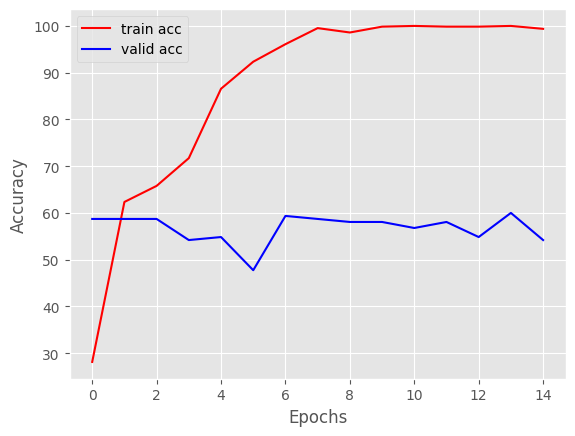

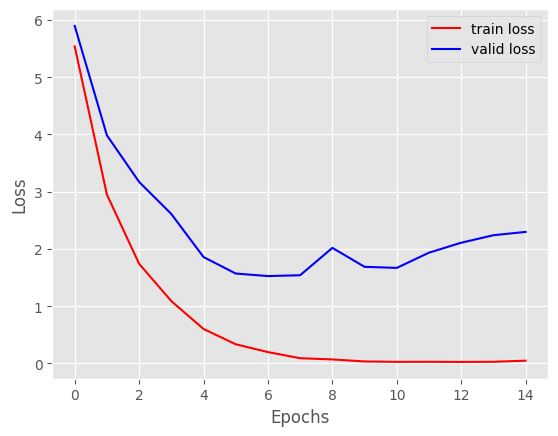

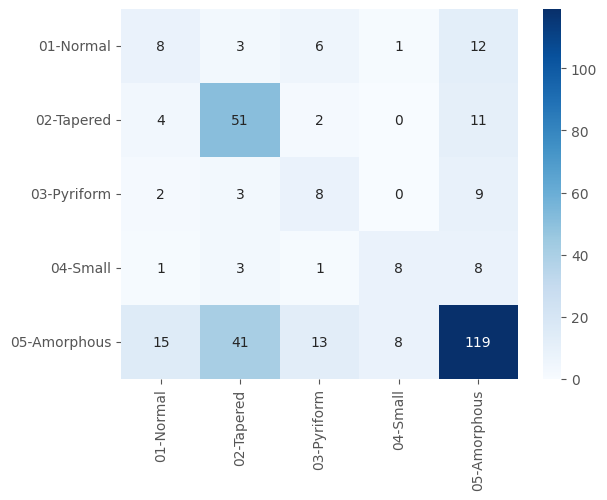

In [26]:
main_path = '/home/mcoronado/Escritorio/Codigo-Memoria/'
raw_dataset_name = 'raw_data'
dataset_name = 'data'

test_porcentage = 0.3
valid_porcentage = 0.7*0.2
train_porcentage = 0.7*0.8

image_dimention = (35,35)
batch_size = 64
learning_rate = 0.0001
epochs = 15

create_dataset(path_expertAnotations = main_path+'Data-set/PA-expert-annotations.txt', 
              path_partialImages = main_path+'Data-set/Partial-Agreement-Images/',
              dest_path = main_path+'Data-set',
              dataset_name = raw_dataset_name)

remove_black_corners( main_path+'Data-set/Partial-Agreement-Images/', main_path+'Data-set' )

create_train_valid_test(origin_path=main_path+'Data-set/'+raw_dataset_name,
                        dest_path=main_path+'Data-set/',
                        dataset_name = dataset_name,
                        porcentages = [test_porcentage,valid_porcentage,train_porcentage])

dataset_path = main_path+'Data-set/'+dataset_name

trainloader, validloader, testloader = load_data_pytorch_format( dataset_path, batch_size, image_dimention)

#net = models.resnet34()
#net = models.resnet50()
#net = models.vgg19()
#net = models.densenet161()
#net = models.densenet169()

net = models.resnet18()
model_name = 'resnet18_random_v2'


#for setting the weights you can use:

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

model_path = main_path+'outputs/'+model_name
create_folder_wremoving('outputs', main_path)
create_folder_wremoving(model_name, main_path+'outputs/')

#net.apply(random_init) #Model here is the model that you have created


process_net( net , epochs, trainloader, validloader, testloader, optimizer, criterion, model_path)